In [1]:
import os
import glob
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm  # For progress display


Custom Dataset class

In [2]:
class ProposalDataset(Dataset):
    def __init__(self, labeled_proposals_dir, images_dir, image_ids, label_encoder, transform=None):
        self.labeled_proposals_dir = labeled_proposals_dir
        self.images_dir = images_dir
        self.image_ids = image_ids
        self.transform = transform
        self.label_encoder = label_encoder

        # Define acceptable image extensions
        image_extensions = ['.jpg']

        self.samples = []
        for image_id in self.image_ids:
            # Strip file extension if present
            image_id = os.path.splitext(image_id)[0]
            proposal_file = os.path.join(self.labeled_proposals_dir, image_id + '_labeled_proposals.npy')

            # Search for image files with known extensions (case-insensitive)
            image_files = []
            for ext in image_extensions:
                pattern = os.path.join(self.images_dir, image_id + ext)
                image_files.extend(glob.glob(pattern))
                # Also check for uppercase extensions
                pattern_upper = os.path.join(self.images_dir, image_id + ext.upper())
                image_files.extend(glob.glob(pattern_upper))

            if not image_files:
                print(f"No image files found for '{image_id}' in '{self.images_dir}'. Skipping.")
                continue
            image_path = image_files[0]  # Use the first matching image file

            if not os.path.exists(proposal_file):
                print(f"Labeled proposals for '{image_id}' not found at '{proposal_file}'. Skipping.")
                continue

            labeled_proposals = np.load(proposal_file, allow_pickle=True)
            if len(labeled_proposals) == 0:
                print(f"No proposals found in '{proposal_file}'. Skipping '{image_id}'.")
                continue

            for proposal in labeled_proposals:
                if 'box' not in proposal or 'label' not in proposal:
                    print(f"Invalid proposal format in '{proposal_file}'. Skipping proposal.")
                    continue
                box = proposal['box']
                label = proposal['label']
                self.samples.append({'image_path': image_path, 'box': box, 'label': label})

        print(f"Loaded {len(self.samples)} samples for dataset with {len(self.image_ids)} image IDs.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image_path = sample['image_path']
        box = sample['box']
        label = sample['label']

        # Load image
        with Image.open(image_path) as img:
            # Crop the proposal
            x, y, w, h = box
            cropped_img = img.crop((x, y, x + w, y + h)).convert('RGB')
            if self.transform:
                cropped_img = self.transform(cropped_img)
            else:
                # Default transformations
                cropped_img = cropped_img.resize((224, 224))
                cropped_img = np.array(cropped_img).astype(np.float32) / 255.0
                # Convert HWC to CHW format
                cropped_img = np.transpose(cropped_img, (2, 0, 1))
                cropped_img = torch.tensor(cropped_img)

        # Encode label
        label_encoded = self.label_encoder.transform([label])[0]
        label_encoded = torch.tensor(label_encoded, dtype=torch.long)

        return cropped_img, label_encoded


# Handle class Imbalance


1. The CrossEntropy fiunction can accept a weight parameter, which assigns a weight to each class. This makes the loss fucntion pay more attention to underrrepresented classes.
2. To compute_class_weights: weights= total_samples/(num_classes*count)
3. The WeightedRandomSampler allows the DataLoader to sample elements based on assigned weights, ensuring that each class is represented proportionally during training.

Basically Instead of using a fixed ratio of 75-25 it calculates the ratios by counting the negative and positive classes. Then this is 

In [3]:
def compute_class_weights(dataset, num_classes):
    """
    Computes class weights based on the dataset.

    Args:
        dataset (Dataset): Instance of ProposalDataset.
        num_classes (int): Total number of classes.

    Returns:
        torch.Tensor: Class weights.
    """
    # Count the frequency of each class
    labels = [sample['label'] for sample in dataset.samples]
    label_counts = Counter(labels)
    total_samples = len(labels)
    class_weights = []

    for label in dataset.label_encoder.classes_:
        count = label_counts.get(label, 0)
        weight = total_samples / (num_classes * count) if count > 0 else 0
        class_weights.append(weight)

    class_weights = torch.tensor(class_weights, dtype=torch.float)
    return class_weights

def create_sampler(dataset, class_weights):
    """
    Creates a weighted sampler to handle class imbalance.

    Args:
        dataset (Dataset): Instance of ProposalDataset.
        class_weights (torch.Tensor): Class weights.

    Returns:
        WeightedRandomSampler: Sampler for DataLoader.
    """
    # Get the labels for all samples
    labels = [dataset.label_encoder.transform([sample['label']])[0] for sample in dataset.samples]
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler


DataLoader function

In [4]:
def get_data_loaders(labeled_proposals_dir, images_dir, splits_file, batch_size=32):
    # Load splits
    with open(splits_file, 'r') as f:
        splits = json.load(f)
    train_ids = splits.get('train', [])
    test_ids = splits.get('test', [])

    # Strip file extensions from image IDs
    train_ids = [os.path.splitext(image_id)[0] for image_id in train_ids]
    test_ids = [os.path.splitext(image_id)[0] for image_id in test_ids]

    # Further split training IDs for validation
    train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

    # Fit label encoder on all labels
    label_encoder = LabelEncoder()
    all_labels = []
    for ids in [train_ids, val_ids, test_ids]:
        for image_id in ids:
            image_id = os.path.splitext(image_id)[0]  # Ensure no extension
            proposal_file = os.path.join(labeled_proposals_dir, image_id + '_labeled_proposals.npy')
            if os.path.exists(proposal_file):
                labeled_proposals = np.load(proposal_file, allow_pickle=True)
                labels = [proposal['label'] for proposal in labeled_proposals]
                all_labels.extend(labels)
    label_encoder.fit(all_labels)
    num_classes = len(label_encoder.classes_)

    # Define transformations
    """  transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  # Converts to [0, 1] and rearranges dimensions
    ])
    """
    """    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]) """
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.Pad((0, 0, 256, 256), fill=0, padding_mode='constant'),  # Adjust padding as needed
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
    # Create datasets
    train_dataset = ProposalDataset(labeled_proposals_dir, images_dir, train_ids, label_encoder, transform=transform)
    val_dataset = ProposalDataset(labeled_proposals_dir, images_dir, val_ids, label_encoder, transform=transform)
    test_dataset = ProposalDataset(labeled_proposals_dir, images_dir, test_ids, label_encoder, transform=transform)

    # Compute class weights
    class_weights = compute_class_weights(train_dataset, num_classes)

    # Create sampler for training dataset
    sampler = create_sampler(train_dataset, class_weights)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Print number of samples
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Number of testing samples: {len(test_dataset)}")

    return train_loader, val_loader, test_loader, num_classes, label_encoder, class_weights


CNN

In [5]:
class ProposalClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ProposalClassifierCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Assuming RGB images
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjust based on input image size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First conv layer
        x = self.pool(F.relu(self.conv2(x)))  # Second conv layer
        x = x.view(x.size(0), -1)            # Flatten
        x = F.relu(self.fc1(x))              # Fully connected layer
        x = self.dropout(x)
        x = self.fc2(x)                      # Output layer
        return x


Evaluation Funtion

In [6]:
def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluates the model on a dataset.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for the dataset.
        criterion: Loss function.
        device: Device ('cpu' or 'cuda').

    Returns:
        float: Average loss.
        float: Accuracy.
    """
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = running_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


Training function

In [7]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

                # Update progress bar
                pbar.set_postfix({'Loss': loss.item()})
                pbar.update(1)

        epoch_loss = running_loss / total_samples
        epoch_acc = total_correct / total_samples
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n')

    return model, history


In [8]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_loader, label_encoder, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix on Validation Set')
    plt.show()


Main

In [10]:
def main():
    # Directories (update paths accordingly)
    labeled_proposals_dir = '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB'  # Update this path
    images_dir = 'Potholes/Potholes/annotated-images'                 # Update this path
    splits_file = '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/splits.json'                     # Update this path

    # Hyperparameters
    num_epochs = 10
    batch_size = 264
    learning_rate = 0.01

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get DataLoaders
    train_loader, val_loader, test_loader, num_classes, label_encoder, class_weights = get_data_loaders(
        labeled_proposals_dir, images_dir, splits_file, batch_size=batch_size
    )

    # Initialize model
    model = ProposalClassifierCNN(num_classes)

    # Loss and optimizer
    # Use class weights in the loss function to handle class imbalance
    class_weights_tensor = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    # Correctly unpack the returned tuple
    model, history = train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device)

    # Now you can use both `model` and `history` as needed
    # For example, evaluate on the test set
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Save the model
    torch.save(model.state_dict(), 'proposal_classifier_NMS_box.pth')
    print("Model saved as 'proposal_classifier.pth'.")

    # Optionally, plot training history and confusion matrix here
    plot_training_history(history)
    plot_confusion_matrix(model, val_loader, label_encoder, device)


Run

Labeled proposals for 'img-71' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-71_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-129' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-129_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-191' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-191_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-85' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-85_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-48' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-48_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-130' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-130_labeled_proposals.npy'. Sk

Epoch 1/10: 100%|██████████| 55/55 [01:11<00:00,  1.30s/batch, Loss=0.0985]


Epoch [1/10], Train Loss: 0.6181, Train Acc: 0.5207, Val Loss: 1.6580, Val Acc: 0.1692



Epoch 2/10: 100%|██████████| 55/55 [01:11<00:00,  1.30s/batch, Loss=0.156] 


Epoch [2/10], Train Loss: 0.1166, Train Acc: 0.5432, Val Loss: 1.6564, Val Acc: 0.1640



Epoch 3/10: 100%|██████████| 55/55 [01:11<00:00,  1.30s/batch, Loss=0.0918]


Epoch [3/10], Train Loss: 0.1099, Train Acc: 0.5695, Val Loss: 1.5118, Val Acc: 0.1447



Epoch 4/10: 100%|██████████| 55/55 [01:11<00:00,  1.30s/batch, Loss=0.106] 


Epoch [4/10], Train Loss: 0.1040, Train Acc: 0.5805, Val Loss: 1.7308, Val Acc: 0.1946



Epoch 5/10: 100%|██████████| 55/55 [01:12<00:00,  1.31s/batch, Loss=0.131] 


Epoch [5/10], Train Loss: 0.0969, Train Acc: 0.6008, Val Loss: 1.7567, Val Acc: 0.2430



Epoch 6/10: 100%|██████████| 55/55 [01:11<00:00,  1.30s/batch, Loss=0.0784]


Epoch [6/10], Train Loss: 0.0917, Train Acc: 0.6134, Val Loss: 1.7402, Val Acc: 0.2626



Epoch 7/10: 100%|██████████| 55/55 [01:12<00:00,  1.31s/batch, Loss=0.106] 


Epoch [7/10], Train Loss: 0.0916, Train Acc: 0.6216, Val Loss: 1.2817, Val Acc: 0.2979



Epoch 8/10: 100%|██████████| 55/55 [01:11<00:00,  1.31s/batch, Loss=0.0731]


Epoch [8/10], Train Loss: 0.0914, Train Acc: 0.6318, Val Loss: 1.5795, Val Acc: 0.3123



Epoch 9/10: 100%|██████████| 55/55 [01:12<00:00,  1.32s/batch, Loss=0.0779]


Epoch [9/10], Train Loss: 0.0822, Train Acc: 0.6382, Val Loss: 1.2991, Val Acc: 0.3219



Epoch 10/10: 100%|██████████| 55/55 [01:12<00:00,  1.32s/batch, Loss=0.075] 


Epoch [10/10], Train Loss: 0.0754, Train Acc: 0.6610, Val Loss: 1.2110, Val Acc: 0.3567

Test Loss: 1.5961, Test Accuracy: 0.3573
Model saved as 'proposal_classifier.pth'.


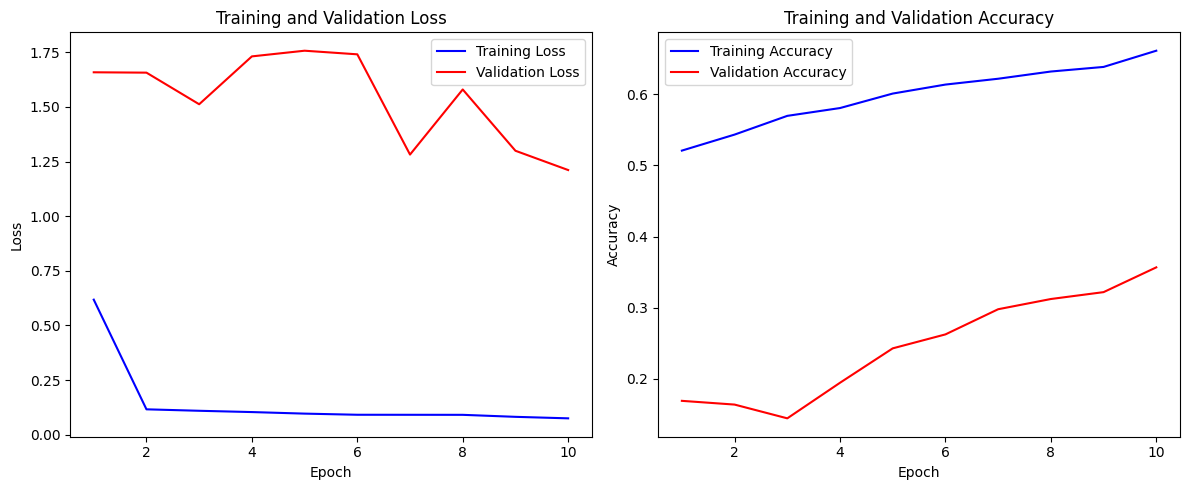

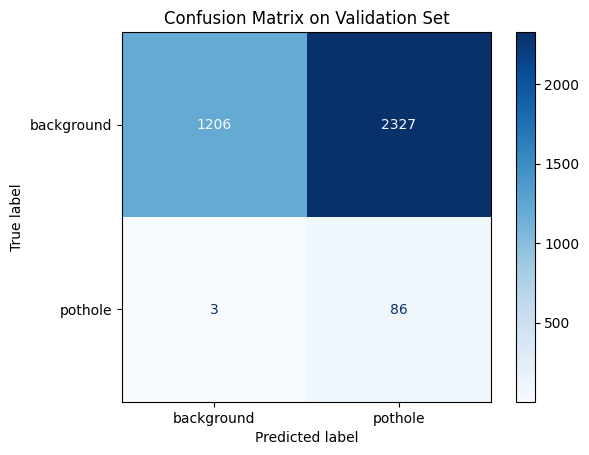

In [11]:
if __name__ == "__main__":
    main()

Fine tune pretrained networks(on ImageNet) by freezing all leyers but the final fully connected layer to match the number of classes in your dataset.

ResNet

In [12]:

import torchvision.models as models
class ProposalClassifierResNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ProposalClassifierResNet, self).__init__()
        # Load pre-trained ResNet-18
        self.model = models.resnet18(pretrained=pretrained)
        
        # Freeze all layers if you don't want to fine-tune
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        return self.model(x)


Labeled proposals for 'img-71' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-71_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-129' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-129_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-191' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-191_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-85' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-85_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-48' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-48_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-130' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-130_labeled_proposals.npy'. Sk

/home/arth/anaconda3/envs/dtu0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arth/anaconda3/envs/dtu0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of training samples: 14406
Number of validation samples: 3622
Number of testing samples: 4453


Epoch 1/10: 100%|██████████| 55/55 [01:10<00:00,  1.28s/batch, Loss=0.0297]


Epoch [1/10], Train Loss: 0.0637, Train Acc: 0.7920, Val Loss: 0.8880, Val Acc: 0.9083



Epoch 2/10: 100%|██████████| 55/55 [01:09<00:00,  1.27s/batch, Loss=0.0195] 


Epoch [2/10], Train Loss: 0.0113, Train Acc: 0.9541, Val Loss: 1.0619, Val Acc: 0.9440



Epoch 3/10: 100%|██████████| 55/55 [01:09<00:00,  1.27s/batch, Loss=0.00294]


Epoch [3/10], Train Loss: 0.0062, Train Acc: 0.9771, Val Loss: 1.0242, Val Acc: 0.9456



Epoch 4/10: 100%|██████████| 55/55 [01:09<00:00,  1.27s/batch, Loss=0.00116] 


Epoch [4/10], Train Loss: 0.0047, Train Acc: 0.9813, Val Loss: 1.3582, Val Acc: 0.9680



Epoch 5/10: 100%|██████████| 55/55 [01:09<00:00,  1.27s/batch, Loss=0.00378] 


Epoch [5/10], Train Loss: 0.0023, Train Acc: 0.9913, Val Loss: 1.2738, Val Acc: 0.9619



Epoch 6/10: 100%|██████████| 55/55 [01:10<00:00,  1.28s/batch, Loss=0.0019]  


Epoch [6/10], Train Loss: 0.0008, Train Acc: 0.9974, Val Loss: 1.3791, Val Acc: 0.9699



Epoch 7/10: 100%|██████████| 55/55 [01:10<00:00,  1.28s/batch, Loss=0.000185]


Epoch [7/10], Train Loss: 0.0005, Train Acc: 0.9979, Val Loss: 1.7893, Val Acc: 0.9754



Epoch 8/10: 100%|██████████| 55/55 [01:09<00:00,  1.27s/batch, Loss=5.97e-5] 


Epoch [8/10], Train Loss: 0.0002, Train Acc: 0.9994, Val Loss: 1.8730, Val Acc: 0.9768



Epoch 9/10: 100%|██████████| 55/55 [01:09<00:00,  1.26s/batch, Loss=1.4e-5]  


Epoch [9/10], Train Loss: 0.0001, Train Acc: 0.9999, Val Loss: 1.7961, Val Acc: 0.9754



Epoch 10/10: 100%|██████████| 55/55 [01:08<00:00,  1.25s/batch, Loss=0.000169]


Epoch [10/10], Train Loss: 0.0001, Train Acc: 0.9997, Val Loss: 2.1347, Val Acc: 0.9768

Test Loss: 2.1639, Test Accuracy: 0.9802
Model saved as 'proposal_classifier_resnet.pth'.


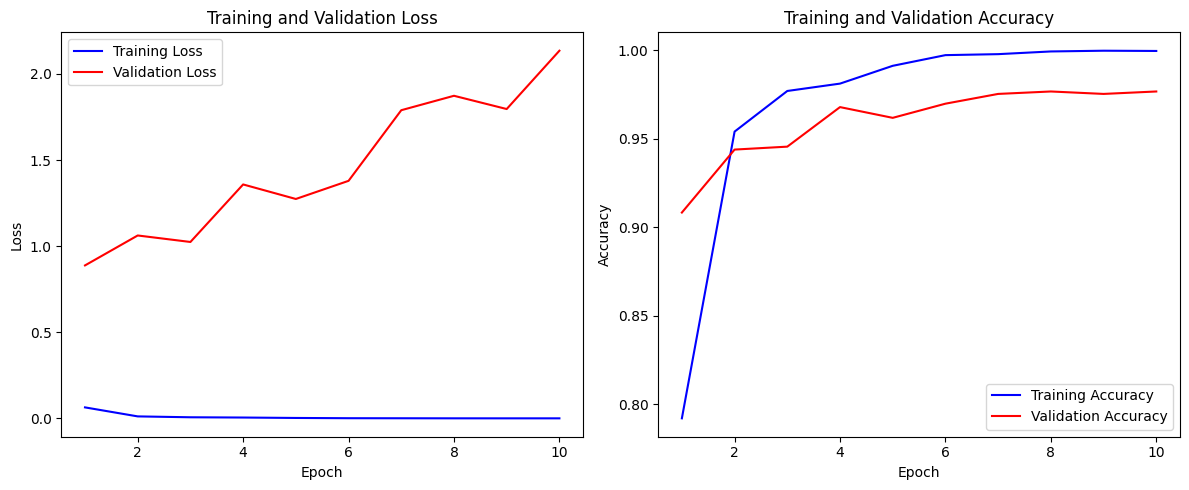

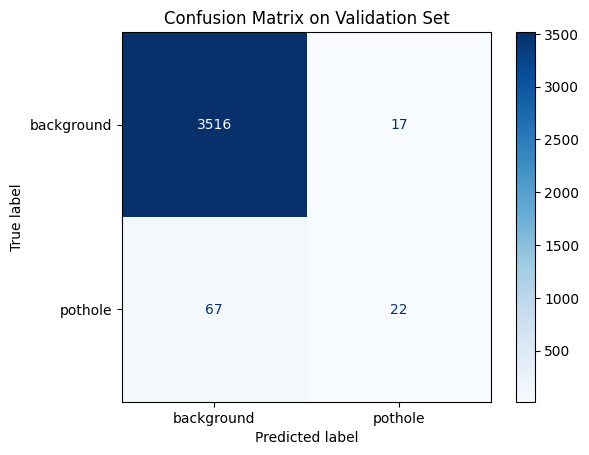

In [13]:
def main():
    # Directories (update paths accordingly)
    labeled_proposals_dir = '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB'
    images_dir = 'Potholes/Potholes/annotated-images'
    splits_file = '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/splits.json'

    # Hyperparameters
    num_epochs = 10
    batch_size = 264
    learning_rate = 0.001

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get DataLoaders
    train_loader, val_loader, test_loader, num_classes, label_encoder, class_weights = get_data_loaders(
        labeled_proposals_dir, images_dir, splits_file, batch_size=batch_size
    )

    # Initialize pre-trained ResNet model
    model = ProposalClassifierResNet(num_classes, pretrained=True)
    model = model.to(device)
    
    # Optionally, fine-tune some layers
    # Example: Unfreeze layer4
    for name, param in model.model.named_parameters():
        if "layer4" in name:
            param.requires_grad = True

    # Define loss and optimizer
    class_weights_tensor = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    # Only parameters that require gradients are passed to the optimizer
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Train the model
    model, history = train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device)

    # Evaluate on test set
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Save the model
    torch.save(model.state_dict(), 'proposal_classifier_resnet_NMS_box.pth')
    print("Model saved as 'proposal_classifier_resnet.pth'.")

    # Plot training history and confusion matrix
    plot_training_history(history)
    plot_confusion_matrix(model, val_loader, label_encoder, device)

if __name__ == "__main__":
    main()

VGG16

In [14]:
class ProposalClassifierVGG16(nn.Module):
    def __init__(self, num_classes, pretrained=True, freeze_features=True):
        super(ProposalClassifierVGG16, self).__init__()
        # Load pre-trained VGG16 model
        self.model = models.vgg16(pretrained=pretrained)
        
        if freeze_features:
            # Freeze feature extraction layers
            for param in self.model.features.parameters():
                param.requires_grad = False
        
        # Modify the classifier to match num_classes
        # Original classifier: [4096, 4096, 1000]
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [15]:
def main():
    # Directories (update paths accordingly)
    labeled_proposals_dir = '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB'  # Update this path
    images_dir = 'Potholes/Potholes/annotated-images'                 # Update this path
    splits_file = '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/splits.json'                     # Update this path

    # Hyperparameters
    num_epochs = 10
    batch_size = 264
    learning_rate = 0.001

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Get DataLoaders
    #train_loader, val_loader, test_loader, num_classes, label_encoder = get_data_loaders(
    #    labeled_proposals_dir, images_dir, splits_file, batch_size=batch_size, background_label='background', background_ratio=0.75
    #)
    train_loader, val_loader, test_loader, num_classes, label_encoder, class_weights = get_data_loaders(
        labeled_proposals_dir, images_dir, splits_file, batch_size=batch_size
    )
     
    # Initialize pre-trained VGG16 model
    model = ProposalClassifierVGG16(num_classes=num_classes, pretrained=True, freeze_features=True)
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    
    # Only parameters that require gradients are passed to the optimizer
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Train the model
    model, history = train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device)

    # Evaluate on test set
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Save the model
    torch.save(model.state_dict(), 'proposal_classifier_vgg16_NMS_box.pth')
    print("Model saved as 'proposal_classifier_vgg16_NMS_box.pth'.")

    # Plot training history and confusion matrix
    plot_training_history(history)
    plot_confusion_matrix(model, val_loader, label_encoder, device)
if __name__ == "__main__":
    main()

Using device: cuda
Labeled proposals for 'img-71' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-71_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-129' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-129_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-191' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-191_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-85' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-85_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-48' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-48_labeled_proposals.npy'. Skipping.
Labeled proposals for 'img-130' not found at '/home/arth/Desktop/various/CV/poster3/Potholes/Potholes/NMS/Labeled_Proposals_EB/img-130_labeled

/home/arth/anaconda3/envs/dtu0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arth/anaconda3/envs/dtu0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 55/55 [02:08<00:00,  2.34s/batch, Loss=0.362]


Epoch [1/10], Train Loss: 0.6875, Train Acc: 0.7306, Val Loss: 0.3191, Val Acc: 0.8595



Epoch 2/10: 100%|██████████| 55/55 [02:09<00:00,  2.35s/batch, Loss=0.191]


Epoch [2/10], Train Loss: 0.2683, Train Acc: 0.8843, Val Loss: 0.1374, Val Acc: 0.9547



Epoch 3/10:  29%|██▉       | 16/55 [00:39<01:37,  2.50s/batch, Loss=0.102]


KeyboardInterrupt: 